In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

### Read data

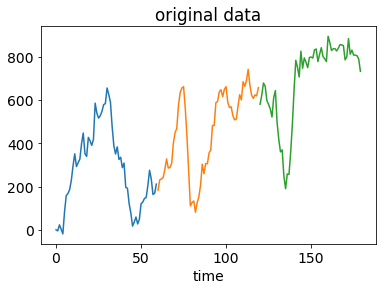

data:  10000


In [3]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

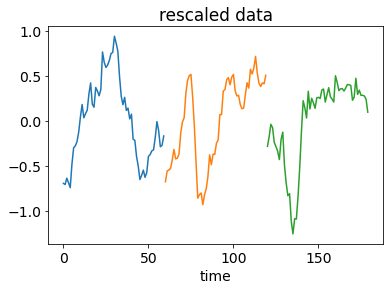

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [4]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [10]:
# ... LESSON ...
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

from keras import regularizers, initializers

reg= regularizers.l2(0.02)
#reg = regularizers.l1(0.02)
ini= keras.initializers.RandomNormal(mean=0.0,stddev=0.05,
                                     seed=None)

NCOVE=1
NF=5

#challenge: at most 600 tunable parameters
model = Sequential()
#
if NCOVE==1:
    #-------2-----
    model.add(Conv1D(filters=NF, kernel_size=11,
                    kernel_initializer=ini,
                    kernel_regularizer=reg,
                    activation='relu',
                    input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7,
                    activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax'))
print('------Model',NCOVE,'----')
print(model.summary())

opt = tf.keras.optimizers.Adam()
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=opt, metrics=['accuracy'])

------Model 1 ----
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 50, 5)             60        
                                                                 
 average_pooling1d_3 (Averag  (None, 10, 5)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_7 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten_2 (Flatten)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                252       
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                   

In [11]:
model.layers

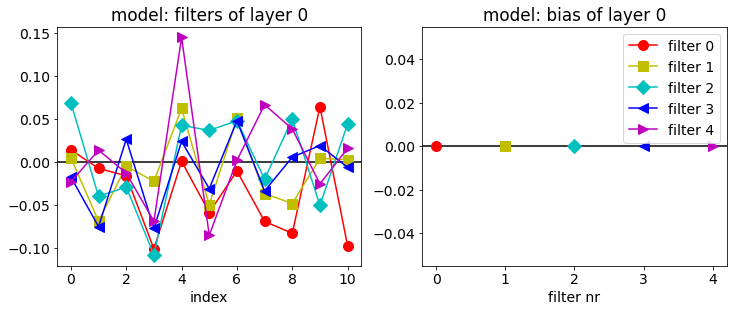

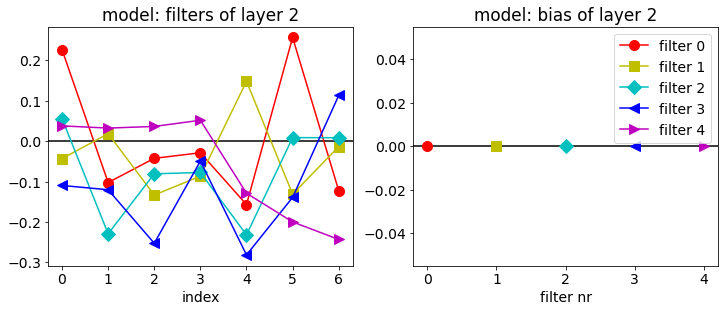

In [12]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [14]:
# ...LESSON ...

BATCH_SIZE=250
EPOCHS = 100

print('-----Model', NCOVE,'------\nFITTING....')
fit= model.fit(x_train, y_train, batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_val, y_val),
              verbose=2, shuffle=True)

-----Model 1 ------
FITTING....
Epoch 1/100
32/32 - 2s - loss: 1.0994 - accuracy: 0.3483 - val_loss: 1.0951 - val_accuracy: 0.3835 - 2s/epoch - 77ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0874 - accuracy: 0.4009 - val_loss: 1.0735 - val_accuracy: 0.4205 - 199ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0498 - accuracy: 0.4794 - val_loss: 1.0219 - val_accuracy: 0.5345 - 200ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9823 - accuracy: 0.5732 - val_loss: 0.9340 - val_accuracy: 0.6545 - 199ms/epoch - 6ms/step
Epoch 5/100
32/32 - 0s - loss: 0.9011 - accuracy: 0.6338 - val_loss: 0.8323 - val_accuracy: 0.7085 - 195ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.7973 - accuracy: 0.6981 - val_loss: 0.7261 - val_accuracy: 0.7655 - 196ms/epoch - 6ms/step
Epoch 7/100
32/32 - 0s - loss: 0.7026 - accuracy: 0.7454 - val_loss: 0.6202 - val_accuracy: 0.8075 - 197ms/epoch - 6ms/step
Epoch 8/100
32/32 - 0s - loss: 0.6106 - accuracy: 0.7795 - val_loss: 0.5253 - val_accuracy: 0.8455 - 1

Epoch 67/100
32/32 - 0s - loss: 0.1164 - accuracy: 0.9740 - val_loss: 0.0973 - val_accuracy: 0.9760 - 194ms/epoch - 6ms/step
Epoch 68/100
32/32 - 0s - loss: 0.1111 - accuracy: 0.9747 - val_loss: 0.0954 - val_accuracy: 0.9790 - 194ms/epoch - 6ms/step
Epoch 69/100
32/32 - 0s - loss: 0.1084 - accuracy: 0.9770 - val_loss: 0.0962 - val_accuracy: 0.9760 - 193ms/epoch - 6ms/step
Epoch 70/100
32/32 - 0s - loss: 0.1070 - accuracy: 0.9772 - val_loss: 0.0931 - val_accuracy: 0.9780 - 191ms/epoch - 6ms/step
Epoch 71/100
32/32 - 0s - loss: 0.1109 - accuracy: 0.9746 - val_loss: 0.0939 - val_accuracy: 0.9800 - 195ms/epoch - 6ms/step
Epoch 72/100
32/32 - 0s - loss: 0.1108 - accuracy: 0.9744 - val_loss: 0.0919 - val_accuracy: 0.9795 - 193ms/epoch - 6ms/step
Epoch 73/100
32/32 - 0s - loss: 0.1075 - accuracy: 0.9764 - val_loss: 0.0905 - val_accuracy: 0.9795 - 192ms/epoch - 6ms/step
Epoch 74/100
32/32 - 0s - loss: 0.1082 - accuracy: 0.9758 - val_loss: 0.0938 - val_accuracy: 0.9790 - 193ms/epoch - 6ms/step


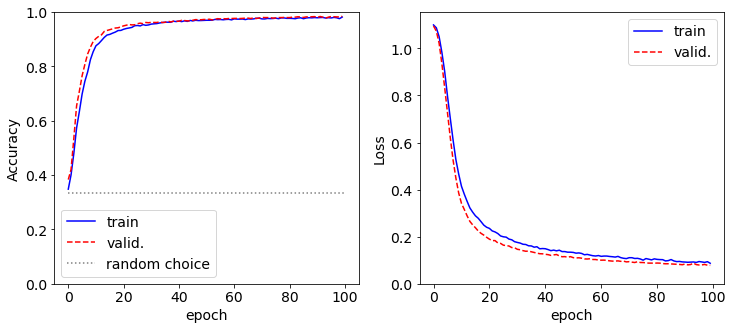

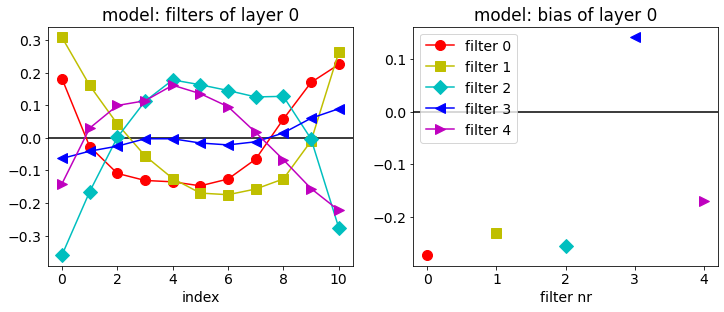

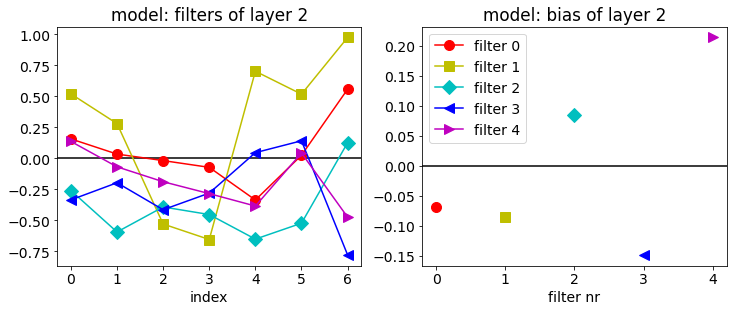

In [15]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

In [ ]:
# ...LESSON ...


In [ ]:
Show_history(fit)
Show_history(fit2)
Show_weights(model2,0,label="model2")
Show_weights(model2,2,label="model2")

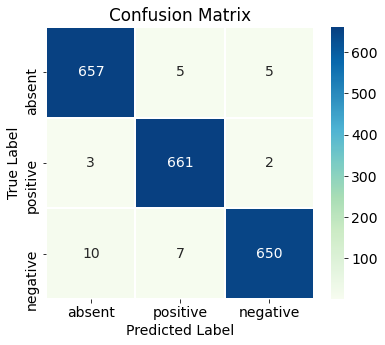

In [16]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))